### Spaceship Titanic Supervised Machine Learning Project: CSCA 5622 ###

For my Final project I am going to execute a supervised learning analysis on a kaggle data set https://www.kaggle.com/competitions/spaceship-titanic/data <br>
Here I am using the "Spaceship Titanic" data from an ongoing Kaggle competition where we will predict which passengers are transported to an alternate dimension.

This project includes 3 deliverables: 
* This Jupyter notebook - including: problem description, EDA procedure, Analysis (model building and training), Result, and Discussion
* A video presentation available on Youtube - Explaining what problem we solved, my ML approach and method, and Final Result
    * https://www.youtube.com/watch?v=lb9QgvX08_Q
* A public github repository - https://github.com/GHeart01/SpaceShip-Titanic-Supervised-ML-Project


#### Table of Contents

- [Problem Description](#Problem-Description)
- [EDA](#Exploratory-Data-Analysis-(EDA)-Procedure)
- [Analysis](#Analysis)
- [Result](#Result)
- [Discussion](#Discussion)
- [Citation](#Citation)

#### Problem Description

First lets take a brief overview of our Machine Learning (ML) problem. In this scenario we explore a play on a well known disaster, The Titanic, in which a "ground truth" for each passenger is determined. Our goal is less gruesome, as instead of life and death on the spaceship titanic we will determine whether almost 13,000 passengers on board will be transported to three habitable exoplanets orbiting nearby stars. Unfortunately, while rounding our first destination, the Spaceship Titanic collided with a spacetime anomaly. While the ship stayed intact, almost half of the passengers were transported to an alternate dimension!  

<div align="center">
  <img src="assets/alpha-c.jpg" width="400"/>
    <br>
Spacetime Anomaly
</div>


To rescue the lost passengers we must use Machine Learning to predict which passengers were transported by the anomaly using records recovered from the spaceship's damaged computer system! <br>

<b> GOAL: For each passenger, predict either <i>True<i> or <i>False<i> for whether or not a passenger was transported off the Spaceship Titanic<b>

In [1]:
# !pip install tensorflow 
# !pip install tensorflow_decision_forests
# !pip install ydf

import subprocess # To avoid extremely long terminal output

packages = ["tensorflow", "tensorflow_decision_forests", "ydf", 
            "statsmodels","pandas","seaborn","numpy","matplotlib",
            "scipy",
            "scikit-learn"
           ]

for pkg in packages:
    try:
        subprocess.run(f"pip install {pkg} --quiet", shell=True, check=True)
        print(f"{pkg} installed successfully!")
    except:
        print(f"Error installing {pkg}, running verbose install:")
        subprocess.run(f"pip install {pkg}", shell=True)

tensorflow installed successfully!
tensorflow_decision_forests installed successfully!
ydf installed successfully!
statsmodels installed successfully!
pandas installed successfully!
seaborn installed successfully!
numpy installed successfully!
matplotlib installed successfully!
scipy installed successfully!
scikit-learn installed successfully!


In [2]:
# Here I will be using tensorflow, we did not use TF in our class lecture, but it contains libraries that are similar to sklearn
import tensorflow as tf
import tensorflow_decision_forests as tfdf

# https://ydf.readthedocs.io/en/stable/
import ydf # Yggdrasil Decision Forests, newer version of tfdf

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import scipy as sp
import scipy.stats as stats
import sklearn


### Exploratory Data Analysis (EDA) Procedure

My task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help make these predictions, I use a given a set of personal records recovered from the ship's damaged computer system.

|Variable |	Description|
|:---------|:-------------|
|PassengerId 	|A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.|
|HomePlanet |	The planet the passenger departed from, typically their planet of permanent residence.|
|CryoSleep |	 Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.|
|Cabin |	The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.|
|Destination |	The planet the passenger will be debarking to.|
|Age| 	 The age of the passenger.|
|VIP |	Whether the passenger has paid for special VIP service during the voyage.|
|RoomService, FoodCourt, ShoppingMall, Spa, VRDeck |	Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.|
|Name |	The first and last names of the passenger.|
|Transported |	Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.|


First I'll do a exploration of the data, looking at the head, and getting information about the dataframe.

In [20]:
# Quick check to see that TF is functional
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

# Load a dataset into a Pandas Dataframe
train = pd.read_csv('spaceship-titanic/train.csv')
test= pd.read_csv('spaceship-titanic/test.csv')

print("Full train dataset shape is {}".format(train.shape))

print("\nHead")
print(train.head(5))
print("\nDescribe")
print(train.describe())
print("\nInfo")
print(train.info())


TensorFlow v2.19.0
TensorFlow Decision Forests v1.12.0
Full train dataset shape is (8693, 14)

Head
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   T

#### Initial data type overview
Here we can see from the info table that there are: <br>
7 object types: PassengerId, HomePlanet, CrypSleep, Cabin, Destination, VIP (status), Name <br>
6 numeric types: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck<br>
and 1 bool: Transported

I'm going set up some graphs to get a visual look how many passengers were transported, and their demographics, as well as variables that correlate.

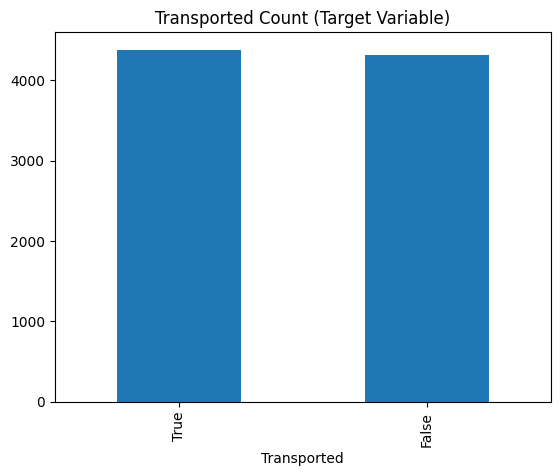

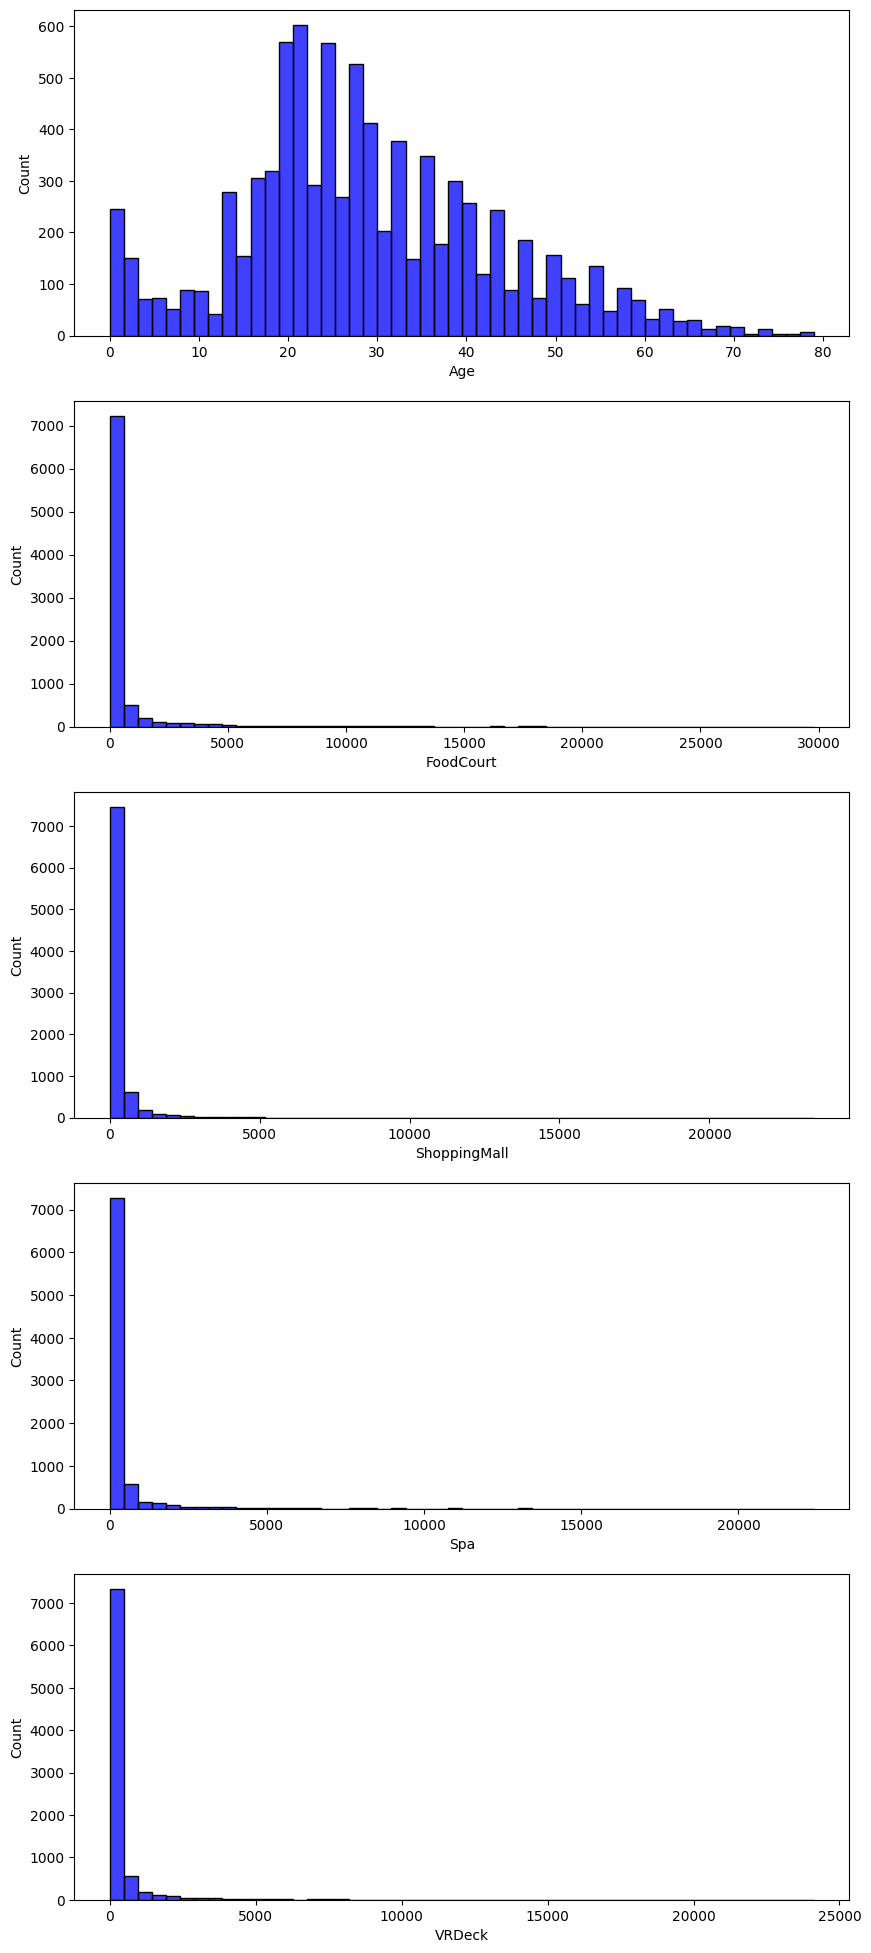

In [4]:
# transported count bar plot
plot_df = train.Transported.value_counts()
plot_df.plot(kind="bar")
plt.title("Transported Count (Target Variable)")
plt.show()  


# histograms
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(train['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(train['FoodCourt'], color='b', bins=50, ax=ax[1]);


sns.histplot(train['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(train['Spa'], color='b', bins=50, ax=ax[3]);

sns.histplot(train['VRDeck'], color='b', bins=50, ax=ax[4]);
plt.show()  

#### Data Cleaning
Now that we have had a look at some charts, lets remove df columns that are not needed for the training.

In [5]:
train = train.drop(['PassengerId', 'Name'], axis=1)
train.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [6]:
train.isnull().sum().sort_values(ascending=False) # check for missing values

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

To get an overview of our feature correlation, I will display a heatmap, and pairplot for dataframe.

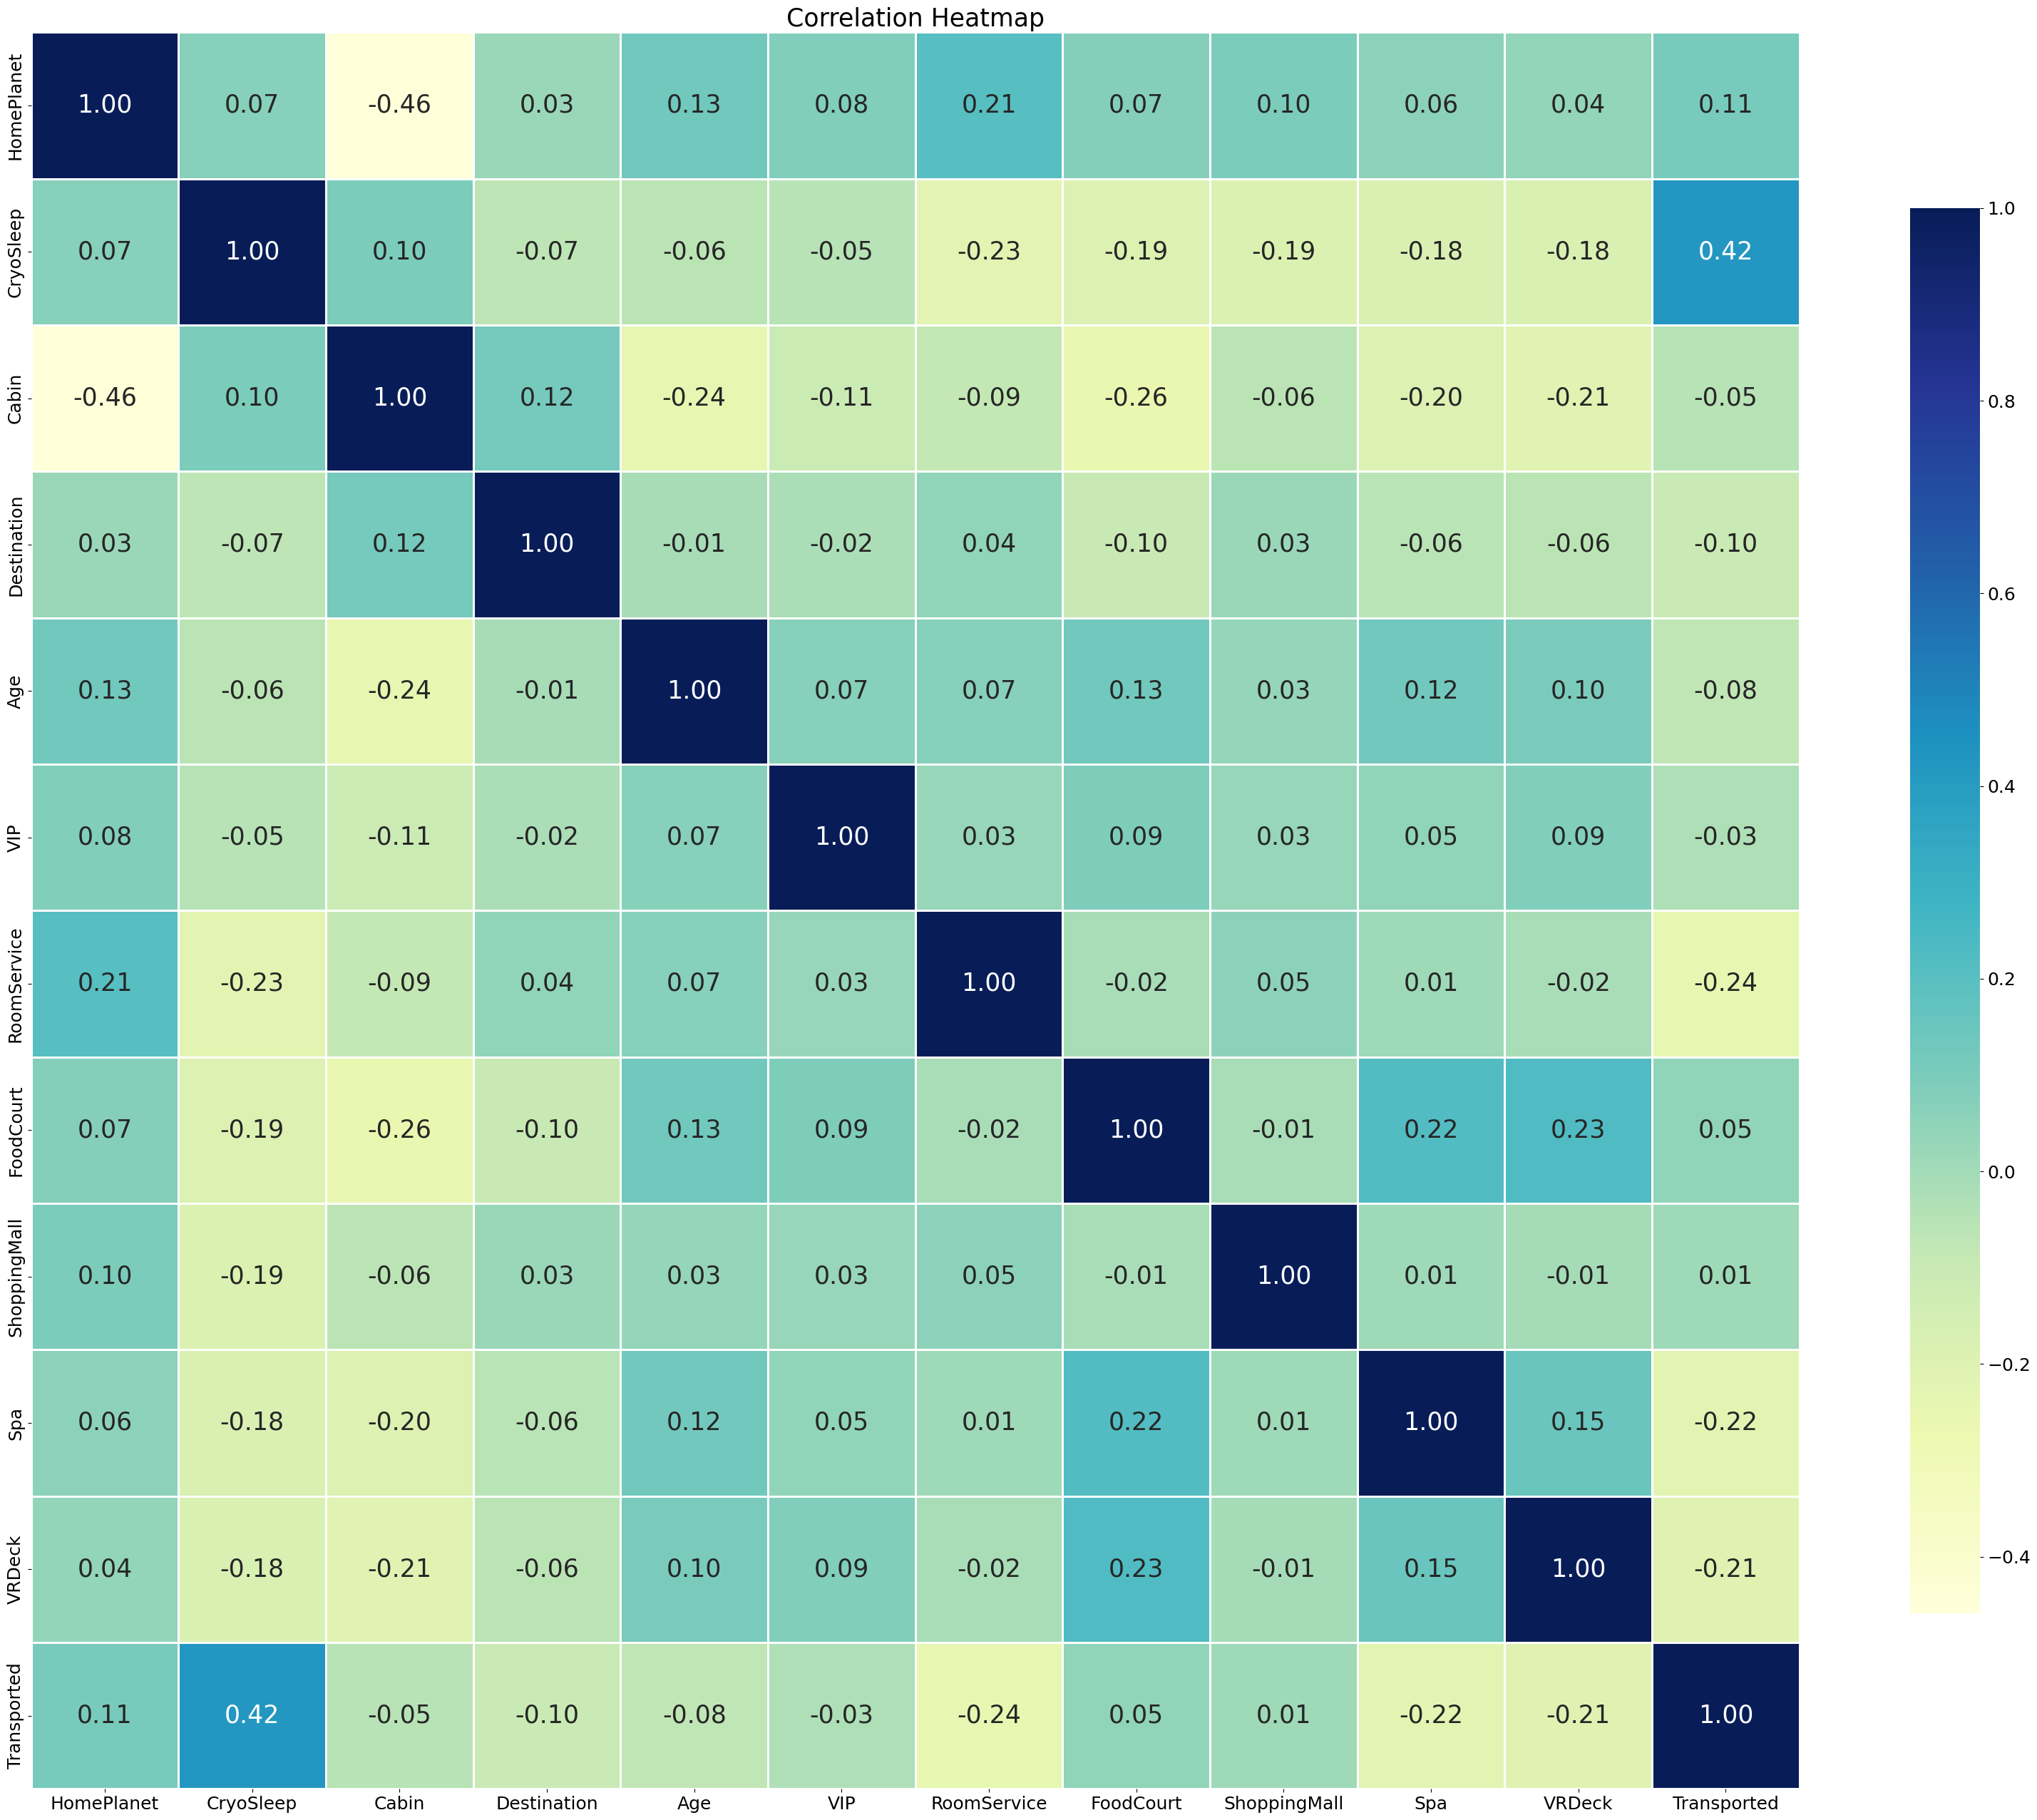

In [7]:
train_encoded = train.copy() # avoid messing with the cleaned data

# non-numeric columns
for col in train_encoded.select_dtypes(exclude='number').columns:
    train_encoded[col] = train_encoded[col].astype('category').cat.codes

# correlation matrix
corr_matrix = train_encoded.corr()

# Plot 
plt.figure(figsize=(40, 32))
heatmap = sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="YlGnBu", 
    fmt=".2f", 
    linewidths=1, 
    annot_kws={"size": 25},
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
plt.show()

Immediately I see a high correlation between CryoSleep and Transported. This indicates that passengers that need to be rescued may have been in cryosleep, that is, they were confined to their pods.

Now the lets look at the pairplot,

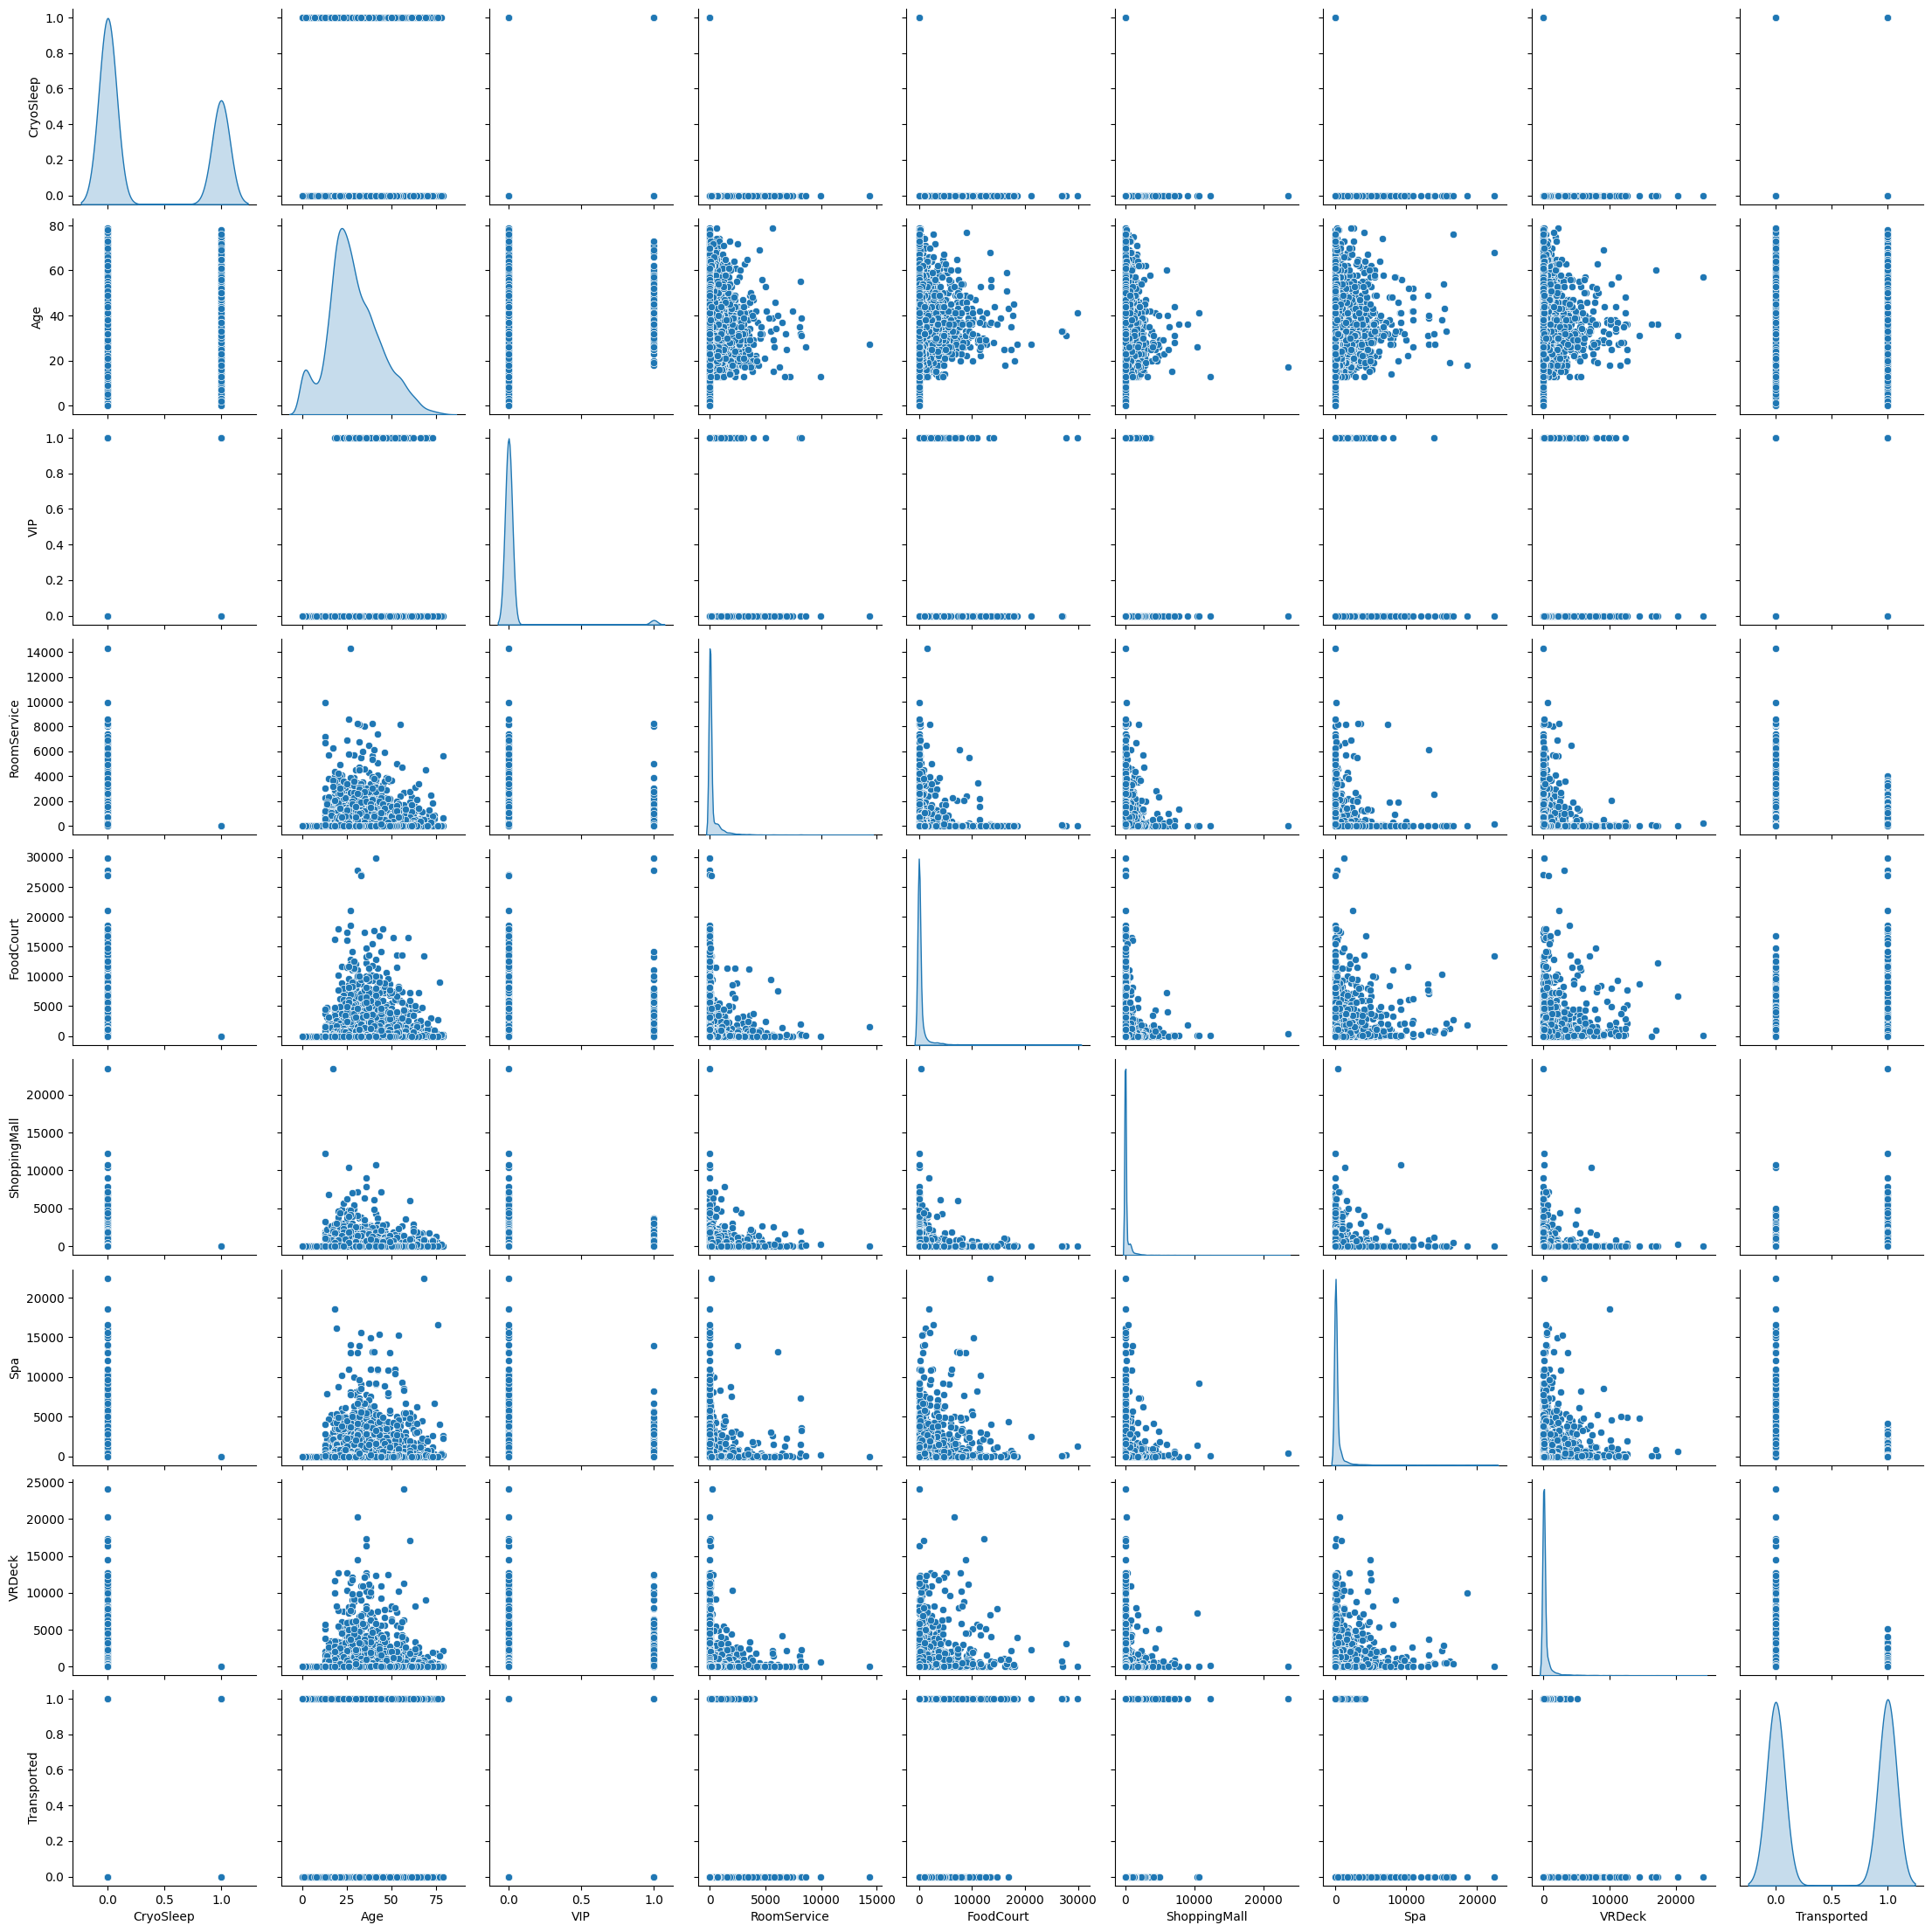

In [8]:
sns.pairplot(
    train,
    diag_kind='kde',  
)

# Title and axis labels
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)

plt.show()

This pairplot provides useful insight, as mentioned in the previous block, cryosleep is linked strongly to the passenger being transported. We also know from the variable definition that being in cryosleep means being confined in their cabin.
Here we an see variables like Spa, VRDeck,etc., where if a passenger is involed in that activity their cryosleep status must be false, otherwise its true. I also see very low correlation with VIP, perhaps a cryosleeper would not choose to be a VIP if they wanted to sleep through transit.

Here I take a closer look at correlation between "Transported" and "Spa", "VRDeck", "RoomService"


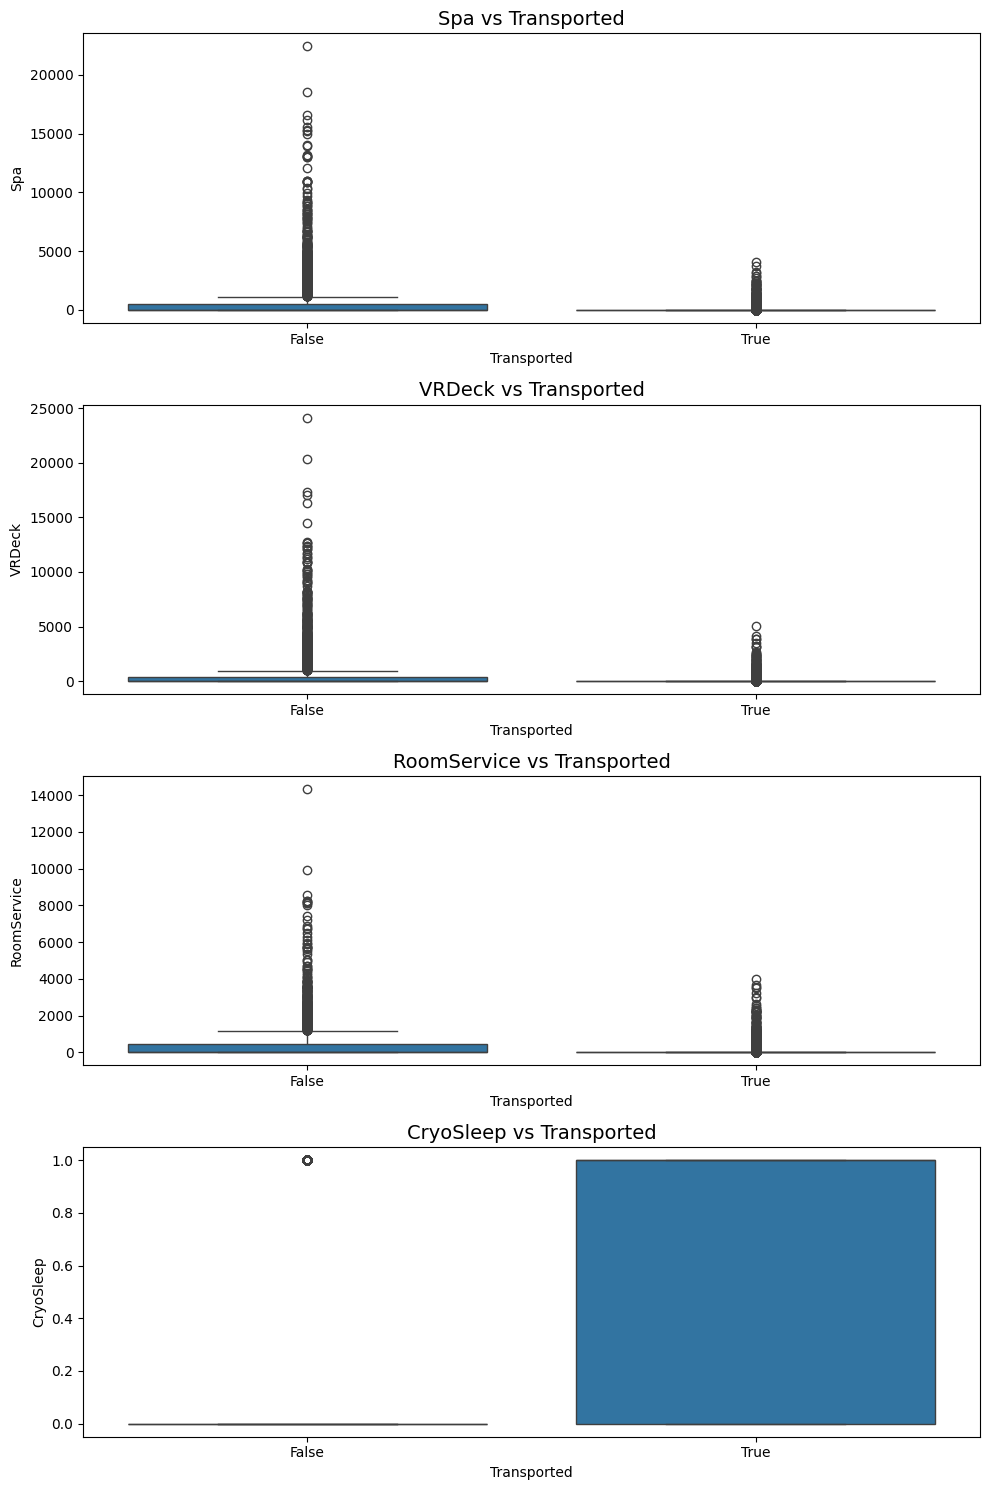

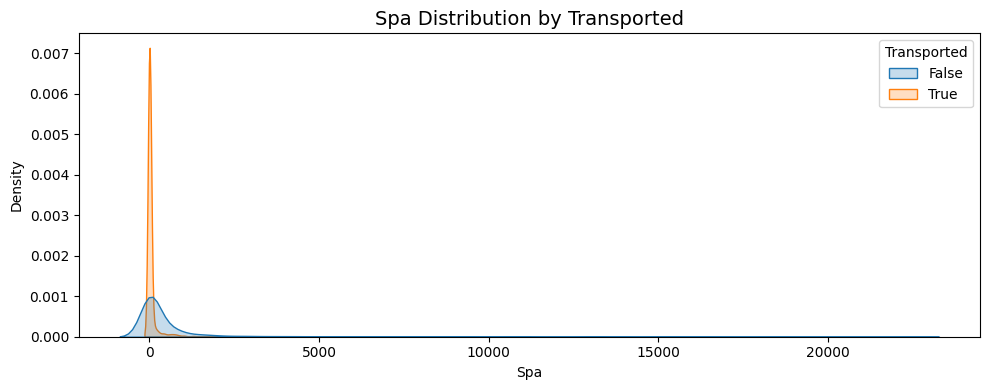

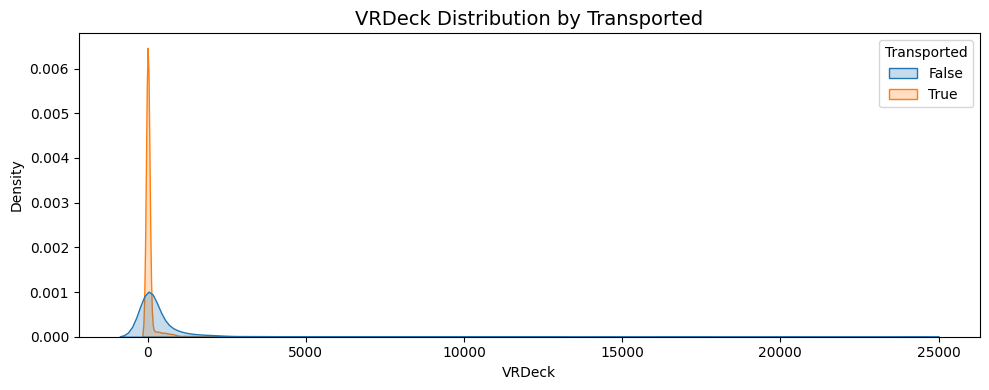

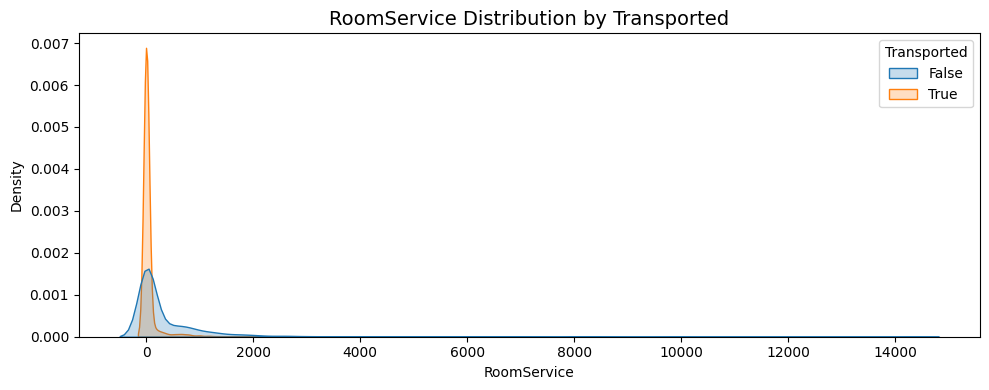

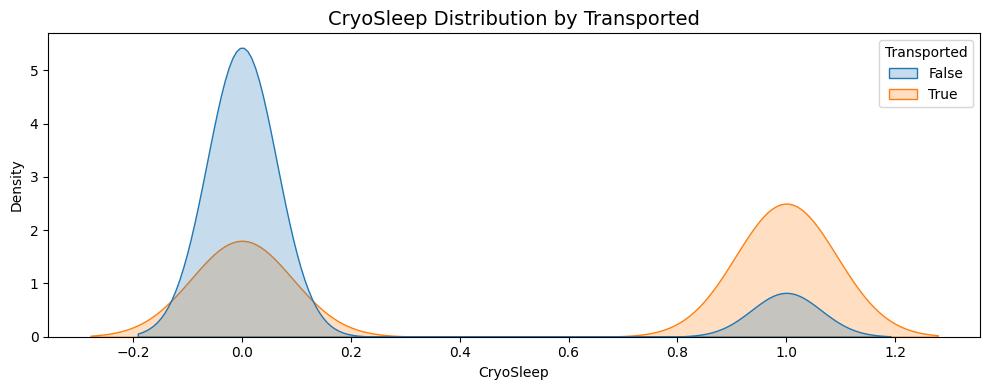

In [9]:
cols = ["Spa", "VRDeck", "RoomService", "CryoSleep"]

plt.figure(figsize=(10, 15)) # put each plot on 1 line

for i, col in enumerate(cols):
    plt.subplot(4, 1, i + 1)
    sns.boxplot(data=train, x="Transported", y=col)
    plt.title(f"{col} vs Transported", fontsize=14)
    plt.xlabel("Transported")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

for col in cols:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(data=train, x=col, hue="Transported", fill=True, common_norm=False)
    plt.title(f"{col} Distribution by Transported", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

As suspected we see very low transported numbers amongst passengers involved in these activites.

Now that we have taken a quick look at the heatmap and pairplot, lets adjust our data for some regression models. Here we see that there are numerical and categorical data, as well as missing features in boolean fields. I will account for the missing features in boolean fields by replacing them with zero. To rid the DF of all null values I will replace null values with 0 for numerical data as well.

In [10]:
train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
train.isnull().sum().sort_values(ascending=False)

HomePlanet      201
Cabin           199
Destination     182
RoomService     181
Age             179
CryoSleep         0
VIP               0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

Here I am going to take the boolean columns and make it numerical by type casting them.

In [11]:
label = "Transported"
train[label] = train[label].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['CryoSleep'] = train['CryoSleep'].astype(int)

From df.head we saw that cabin is combined into deck, cabin_num, and side all in one string. It will be hard to parse the data like that so here i have split the cabin string into three new columns and then dropped the original string column.

In [12]:
train[["Deck", "Cabin_num", "Side"]] = train["Cabin"].str.split("/", expand=True)

try:
    train = train.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

train.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S


Splitting into training and testing datasets, we will be able to new classifiers and regression models on our data. Tensorflow requires its own format, so I'll also be converting the pandas format (pd.DataFrame) into TensorFlow Datasets format (tf.data.Dataset).

In [13]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)


6906 examples in training, 1787 examples in testing.


### Random Forest

Here we will try our first model and look at accuracy.

Use /var/folders/zj/9pt8pkf91b7bn2l7804l92wh0000gn/T/tmpdpnl83hh as temporary training directory


I0000 00:00:1750994430.455791 27745348 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750994430.455806 27745348 kernel.cc:783] Collect training examples
I0000 00:00:1750994430.455810 27745348 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1750994430.455984 27745348 kernel.cc:401] Number of batches: 7
I0000 00:00:1750994430.455987 27745348 kernel.cc:402] Number of examples: 6906
I0000 00:00:1750994430.456958 27745348 data_spec_inference.cc:354] 1260 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Cabin_num (472 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 

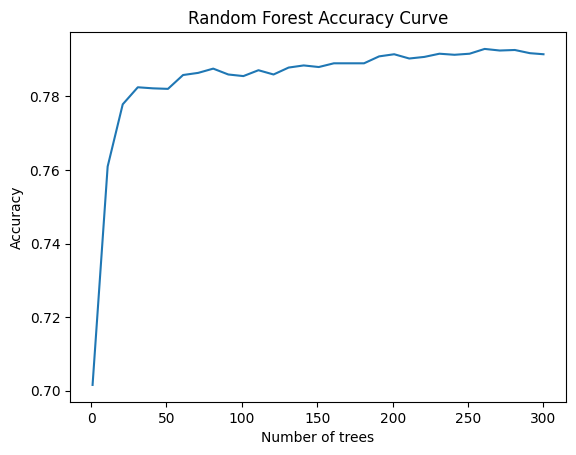

2/2 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 0.7985
loss: 0.0000
accuracy: 0.7985


In [14]:
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"])
rf.fit(x=train_ds, verbose=0) 

# Plot model and accuracy curve 
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.title("Random Forest Accuracy Curve")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.show()

#accuracy 
inspector = rf.make_inspector()
inspector.evaluation()

evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

Here we see Random Forest produces an accuracy of about 80%, lets take a look at a Gradient Boosted Trees Machine model.

#### Gradient Boosted Trees Model

Use /var/folders/zj/9pt8pkf91b7bn2l7804l92wh0000gn/T/tmp17_o2api as temporary training directory


W0000 00:00:1750994439.923567 27745348 gradient_boosted_trees.cc:1873] "goss_alpha" set but "sampling_method" not equal to "GOSS".
W0000 00:00:1750994439.923576 27745348 gradient_boosted_trees.cc:1883] "goss_beta" set but "sampling_method" not equal to "GOSS".
W0000 00:00:1750994439.923577 27745348 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1750994440.013322 27745348 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1750994440.013333 27745348 kernel.cc:783] Collect training examples
I0000 00:00:1750994440.013336 27745348 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: 

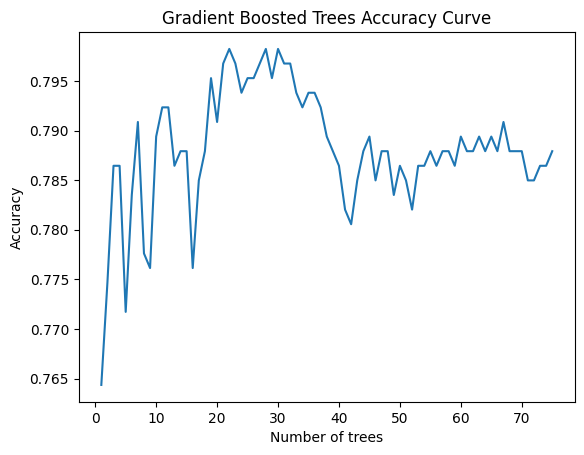

Inspector evaluation (internal):
Evaluation(num_examples=None, accuracy=0.7893961668014526, loss=0.8522018790245056, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8013

Evaluation on validation dataset:
loss: 0.0000
accuracy: 0.8013


In [15]:
gbt = tfdf.keras.GradientBoostedTreesModel()
gbt.compile(metrics=["accuracy"])

# Fit
gbt.fit(x=train_ds, verbose=0)

# Plot first tree 
tfdf.model_plotter.plot_model_in_colab(gbt, tree_idx=0, max_depth=3)

logs = gbt.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.title("Gradient Boosted Trees Accuracy Curve")
plt.show()

# accuracy calculation
inspector = gbt.make_inspector()
print("Inspector evaluation (internal):")
print(inspector.evaluation())

# Evaluate on separate validation dataset
evaluation = gbt.evaluate(x=valid_ds, return_dict=True)

# Print formatted metrics
print("\nEvaluation on validation dataset:")
for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

Here we see the gradient boosted model performs similar to random forest, but both are around of 80% accuracy. Finally I will attempt another model to perform better.

#### Logistic Regression

Here I use the sklearn library again for simplicity, where I plot an ROC curve and print logistic regression summary to determine accuracy of the model.

Optimization terminated successfully.
         Current function value: 0.551189
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Transported   No. Observations:                 8512
Model:                          Logit   Df Residuals:                     8508
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Jun 2025   Pseudo R-squ.:                  0.2048
Time:                        22:20:55   Log-Likelihood:                -4691.7
converged:                       True   LL-Null:                       -5899.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8411      0.030     27.961      0.000       0.782       0.900
Spa            -0.0017   9

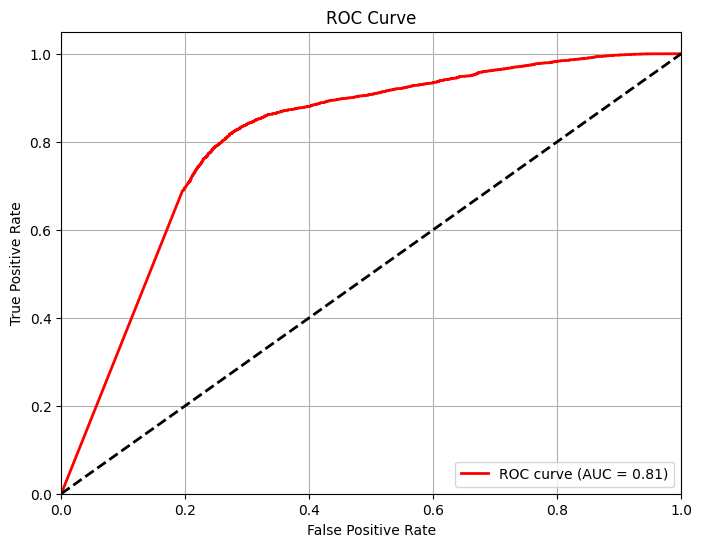

In [16]:
# Import necessary metrics from sklearn
from sklearn.metrics import accuracy_score, roc_curve, auc

# Select relevant columns
features = ['Spa', 'VRDeck', 'RoomService']
target = 'Transported'

# Add constant to X
X = sm.add_constant(train[features])
y = train[target].astype(int)  # Ensure it's numeric (0 or 1)

# Remove rows with missing or infinite values
mask = X.notnull().all(axis=1) & y.notnull()
mask &= np.isfinite(X).all(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Fit the model
logit_model = sm.Logit(y_clean, X_clean)
result = logit_model.fit()
print(result.summary())

# Predict probabilities for entire dataset (including missing rows we'll use for ROC)
train['pred_prob'] = result.predict(X)

# Predict binary outcome (threshold = 0.5) - only for clean data
y_pred_clean = (result.predict(X_clean) > 0.5).astype(int)

# Calculate accuracy on clean data only
print("Accuracy:", accuracy_score(y_clean, y_pred_clean))

## ROC curve
# Compute ROC curve and AUC using clean data
y_scores = result.predict(X_clean)
fpr, tpr, thresholds = roc_curve(y_clean, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='red', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Unfortunately I find that Logistic Regression (LR) is a worse performer than Random Forest and Gradient Boosted Tree Machine methods. This is not surprising as in the last module of our class lecture, we saw that in most datasets RF and GBM we the highest performing of many attempted. I do see that LR seems to be decently ranking positives higher than negatives, which is a strong signal that the model is performing well, However with only 76% accuracy LR falls behind RF and GBM.

### Analysis

I used pandas and numpy for data cleaning and EDA. Matplotlib for plotting to visual inspect data that could be related to our goal, statsmodel, sklearn,scipy, and TensorFlow to model data and determine accuracies. My EDA involved an initial test of reading the data, and a quick look using “.head”, “describe”, and “.info” to determine datatypes of our variables, as well as a look at passengers who were transported. I then used bar and histogram plots to gain a visual of passengers who were transported, and performed data cleaning and data restricting based on tables using “.drop” and “.head”. <br>I created a copy of the data and plotting a heatmap correlation where I found high positive correlation between “Transported” and “CryoSleep”, and high negative correlation with “VRDeck”, “Spa”, and “RoomService”. I then used a pairplot to confirm my visual aid. Then I created bbox and KDE plots for relations between Transported and “VRDeck”, “Spa”, and “RoomService”, and “CryoSleep”. I then adjusted the data for use in Tensorflow and plotted based on Random Forest and Gradient Boosted Method. These methods accurately determined whether a passenger had been transported nearly 80% of the time. In an attempt to push further, I tried a Logistic Regression, which produced an accuracy of about 76%.

<div align="center">
  <img src="assets/RF.png" width="500"/> <img src="assets/GBM.png" width="500"/>
    <br>
Random Forest Vs. Gradient Boosted Machine</div>

### Result

After exploration of the data, data cleaning, and variable management (in the case of "cabin"), we see an accuracy of roughtly 80% success across our models, with RF performing as the most accurate model for finding the missing passengers. "Spa", "VRDeck", "RoomService", and "CryoSleep" all heavily weiged whether a passenger would be transported or not. In addition, by converting non integer type data variables to integer types, thus making all the data numeric, it made it much more determinable to find out whether a passenger had been transported via a 0 (False) or 1 (True). My result is the Random Forest method was the possible accurate at determining whether a passenger was missing or not.

### Discussion

I targeted "Spa", "VRDeck", "RoomService" as variables to use for finding the missing passengers. While I did not include other variables in the notebook, I did attempt the models using additional variables to see how the models would perform; and no additional variables ever increased accuracy. I utilized boxplots and KDEplots to confirm my visual assumptions from the the heatmap. In addition I used a pairplot to gain additional validation of correlations from transported passengers and other variables. These decisions were aided on my inital EDA and plotting of possible demographics affected by the anomaly.
From my models, Random Forest and Gradient Boosted Machine performed well. Both models performed at around 80%. Logistic Regression performed noticably worse at around 76% accuracy, which isnt bad, but is certainly worse. There is certainly room for contest of my result as I utilized libraries from tensorflow for RF and GBM, while I used Sklearn for the Logistic Regression. I believe I could improve my accuraccy beyond 80% if I utilize cabin section in a more direct manner, as it may be that a part of the ship, say cabin section C, is more impacted that other cryosleep chambers.

### Citation

Addison Howard, Ashley Chow, and Ryan Holbrook. Spaceship Titanic. https://kaggle.com/competitions/spaceship-titanic, 2022. Kaggle.